<a href="https://colab.research.google.com/github/Tej-55/SAiDL-Summer-Assignment-2023-Core_ML/blob/main/Variations_of_Softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time

In [ ]:
# First load the CIFAR-100 from tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

169001437/169001437 [==============================] - 13s 0us/step


In [ ]:
# Scale pixel value to [0,1] float values
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [ ]:
# Convert labels to OHE
y_train = tf.keras.utils.to_categorical(y_train, num_classes=100)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=100)

In [ ]:

class TimeHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        super(TimeHistory, self).__init__()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        mean_epoch_time = np.mean(self.epoch_times)
        logs["mean_epoch_time"] = mean_epoch_time

# Using Normal Softmax
Complexity: O(n)

In [ ]:
# Make the model (I have used functional API)
def functional_model():
  inputs = layers.Input(shape=(32, 32, 3))
  x = layers.Conv2D(32, (3, 3), activation="relu")(inputs)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Conv2D(64, (3, 3), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation="relu")(x)
  outputs = layers.Dense(100, activation="softmax")(x)
  return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compile and train
model = functional_model()
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test), callbacks=[TimeHistory()])

Epoch 1/10
782/782 [==============================] - 21s 10ms/step - loss: 3.8307 - accuracy: 0.1189 - val_loss: 3.3682 - val_accuracy: 0.2045 - mean_epoch_time: 21.0878
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 3.1084 - accuracy: 0.2439 - val_loss: 2.9796 - val_accuracy: 0.2685 - mean_epoch_time: 12.8157
Epoch 3/10
782/782 [==============================] - 6s 7ms/step - loss: 2.7782 - accuracy: 0.3058 - val_loss: 2.7704 - val_accuracy: 0.3097 - mean_epoch_time: 10.4460
Epoch 4/10
782/782 [==============================] - 5s 7ms/step - loss: 2.5594 - accuracy: 0.3543 - val_loss: 2.6890 - val_accuracy: 0.3258 - mean_epoch_time: 9.1093
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 2.4037 - accuracy: 0.3892 - val_loss: 2.6163 - val_accuracy: 0.3465 - mean_epoch_time: 8.2721
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 2.2720 - accuracy: 0.4116 - val_loss: 2.5523 - val_accuracy: 0.3571 - mean_epoch_

In [ ]:
# Predict the classes of the test set
y_pred = model.predict(x_test)
y_pred_classes = tf.argmax(y_pred, axis=1)
y_true_classes = tf.argmax(y_test, axis=1)

# Compute evaluation metrics
acc = accuracy_score(y_true_classes, y_pred_classes)
prec = precision_score(y_true_classes, y_pred_classes, average='micro')
rec = recall_score(y_true_classes, y_pred_classes, average='micro')
f1 = f1_score(y_true_classes, y_pred_classes, average='micro')
cm = confusion_matrix(y_true_classes, y_pred_classes)

313/313 [==============================] - 1s 4ms/step


In [ ]:
#average training time per epoch
history.history['mean_epoch_time'][-1] 

6.4867209672927855

In [ ]:
acc, prec, rec, f1

(0.3802, 0.3802, 0.3802, 0.3802)

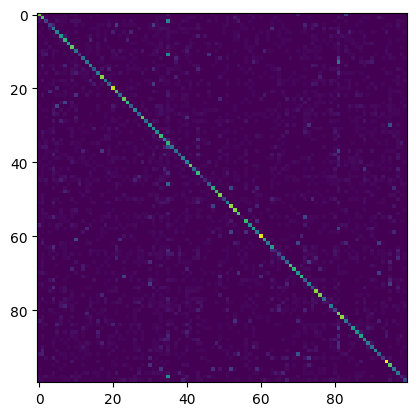

In [ ]:
plt.imshow(cm)

# Using Gumbel Softmax
Complexity: O(n)

In [ ]:
# First we define the gumbel_softmax
def gumbel_softmax(logits, temperature, hard=False):
    # Generate Gumbel noise
    noise = -tf.math.log(-tf.math.log(tf.random.uniform(tf.shape(logits), minval=1e-10, maxval=1.0)))

    # Add noise to logits
    y = logits + noise / temperature

    # Apply softmax
    y = tf.nn.softmax(y, axis=-1)
    return y

In [ ]:
# Make the model (I have used functional API)
def functional_model():
  inputs = layers.Input(shape=(32, 32, 3))
  x = layers.Conv2D(32, (3, 3), activation="relu")(inputs)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Conv2D(64, (3, 3), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation="relu")(x)
  outputs = layers.Dense(100, activation=lambda x: gumbel_softmax(x, 10))(x)
  return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compile and train
model = functional_model()
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test), callbacks=[TimeHistory()])

Epoch 1/10
782/782 [==============================] - 8s 7ms/step - loss: 3.7772 - accuracy: 0.1330 - val_loss: 3.2959 - val_accuracy: 0.2194 - mean_epoch_time: 7.7644
Epoch 2/10
782/782 [==============================] - 6s 7ms/step - loss: 3.0444 - accuracy: 0.2588 - val_loss: 2.9256 - val_accuracy: 0.2800 - mean_epoch_time: 6.7064
Epoch 3/10
782/782 [==============================] - 5s 7ms/step - loss: 2.7173 - accuracy: 0.3234 - val_loss: 2.7619 - val_accuracy: 0.3166 - mean_epoch_time: 6.2058
Epoch 4/10
782/782 [==============================] - 6s 7ms/step - loss: 2.5205 - accuracy: 0.3625 - val_loss: 2.6416 - val_accuracy: 0.3461 - mean_epoch_time: 6.0575
Epoch 5/10
782/782 [==============================] - 6s 7ms/step - loss: 2.3650 - accuracy: 0.3967 - val_loss: 2.5688 - val_accuracy: 0.3602 - mean_epoch_time: 6.0018
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 2.2456 - accuracy: 0.4205 - val_loss: 2.5226 - val_accuracy: 0.3697 - mean_epoch_time:

In [ ]:
# Predict the classes of the test set
y_pred = model.predict(x_test)
y_pred_classes = tf.argmax(y_pred, axis=1)
y_true_classes = tf.argmax(y_test, axis=1)

# Compute evaluation metrics
acc = accuracy_score(y_true_classes, y_pred_classes)
prec = precision_score(y_true_classes, y_pred_classes, average='micro')
rec = recall_score(y_true_classes, y_pred_classes, average='micro')
f1 = f1_score(y_true_classes, y_pred_classes, average='micro')
cm = confusion_matrix(y_true_classes, y_pred_classes)

313/313 [==============================] - 1s 4ms/step


In [ ]:
#average training time per epoch
history.history['mean_epoch_time'][-1] 

5.845056748390197

In [ ]:
acc, prec, rec, f1

(0.3781, 0.3781, 0.3781, 0.3781)

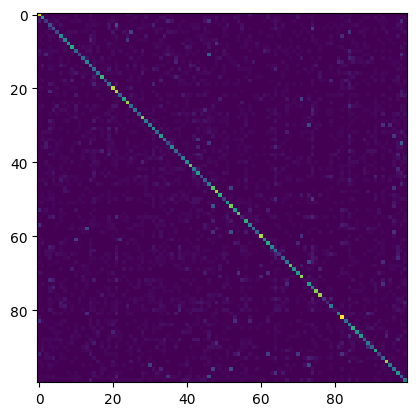

In [ ]:
plt.imshow(cm)

# Hierarchical Softmax
Complexity O(log n)

In [ ]:
# Defining a class Tree
class Tree:
    def __init__(self, leaf_num):
        self.decision = {0:1, 1:-1}
        self.index = 0
        
        arr = []
        arr2 = []
        for path, base, decision, leaf in self.get_decision(self.create_random_tree(leaf_num)): # going through the tree
            temporary = np.zeros((1,leaf_num-1), dtype='float32')
            temporary2 = np.ones((1,leaf_num-1), dtype='float32')
            
            np.put(temporary, path, decision)
            np.put(temporary2, path, base)
            
            arr.append(temporary)
            arr2.append(temporary2)
        self.index = 0    
        self.decision = tf.convert_to_tensor(np.array(arr).reshape((leaf_num, leaf_num-1)))
        self.base = tf.convert_to_tensor(np.array(arr2).reshape((leaf_num, leaf_num-1)))
        
        self.decision = tf.Variable(self.decision, trainable=True)
        self.base = tf.Variable(self.base, trainable=True)
        
    def create_random_tree(self, output_dim): # creates a binary tree structure for the classes 
        outputs = list(range(output_dim))
#        outputs = copy(outputs)
        #shuffle(outputs)
    
        while len(outputs) > 2:
            temp_outputs = []
            for i in range(0, len(outputs), 2):
                if len(outputs) - (i+1) > 0:
                    temp_outputs.append([outputs[i], outputs[i+1]])
                else:
                    temp_outputs.append(outputs[i])
            outputs = temp_outputs
        return outputs

    def get_decision(self, tree): #given tree, gives a path decision
        temp_i = self.index
        self.index += 1
        for i, subtree in enumerate(tree):
            #temp_i = self.index
            if type(subtree) == list:
                for path, base, decision_list, value in self.get_decision(subtree):
                    yield [temp_i] + path, [i]+base, [self.decision[i]]+decision_list, value
            else:
                yield [temp_i], [i], [self.decision[i]],subtree 

# defining the herarchical softmax
def hierarchical_softmax(inp, tree):
    x1 = tf.multiply(tf.reshape(inp, [-1, 1, 1]), tree.decision)
    x1 = tree.base + x1
    return (tf.math.reduce_prod(x1, axis=-1))

In [ ]:
tree = Tree(100)
# defining the model
def functional_model():
  inputs = layers.Input(shape=(32, 32, 3))
  x = layers.Conv2D(32, (3, 3), activation="relu")(inputs)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Conv2D(64, (3, 3), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation="relu")(x)
  outputs = layers.Dense(1, activation=lambda x: hierarchical_softmax(x, tree))(x)
  return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compile and train
model = functional_model()
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
#tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test), callbacks=[TimeHistory()])

Epoch 1/10
782/782 [==============================] - 6s 6ms/step - loss: nan - accuracy: 0.0100 - val_loss: nan - val_accuracy: 0.0100 - mean_epoch_time: 6.2852
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: nan - accuracy: 0.0100 - val_loss: nan - val_accuracy: 0.0100 - mean_epoch_time: 5.2203
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: nan - accuracy: 0.0100 - val_loss: nan - val_accuracy: 0.0100 - mean_epoch_time: 5.0153
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: nan - accuracy: 0.0100 - val_loss: nan - val_accuracy: 0.0100 - mean_epoch_time: 4.7401
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: nan - accuracy: 0.0100 - val_loss: nan - val_accuracy: 0.0100 - mean_epoch_time: 4.5653
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: nan - accuracy: 0.0100 - val_loss: nan - val_accuracy: 0.0100 - mean_epoch_time: 4.6032
Epoch 7/10
782/782 [========

In [ ]:
# Predict the classes of the test set
y_pred = model.predict(x_test)
y_pred_classes = tf.argmax(y_pred, axis=1)
y_true_classes = tf.argmax(y_test, axis=1)

# Compute evaluation metrics
acc = accuracy_score(y_true_classes, y_pred_classes)
prec = precision_score(y_true_classes, y_pred_classes, average='micro')
rec = recall_score(y_true_classes, y_pred_classes, average='micro')
f1 = f1_score(y_true_classes, y_pred_classes, average='micro')
cm = confusion_matrix(y_true_classes, y_pred_classes)

313/313 [==============================] - 1s 2ms/step


In [ ]:
#average training time per epoch
history.history['mean_epoch_time'][-1] 

4.968307137489319

In [ ]:
acc, prec, rec, f1

(0.01, 0.01, 0.01, 0.01)